In [1]:
%matplotlib notebook
import sys
import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
import schwimmbad
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [2]:
#---------------------------------------------------
#       meta data

datadir = 'Data'
metafilename = f'{datadir}/training_set_metadata.csv'
metadata = Table.read(metafilename, format='csv')
nobjects = len(metadata)


<IPython.core.display.Javascript object>


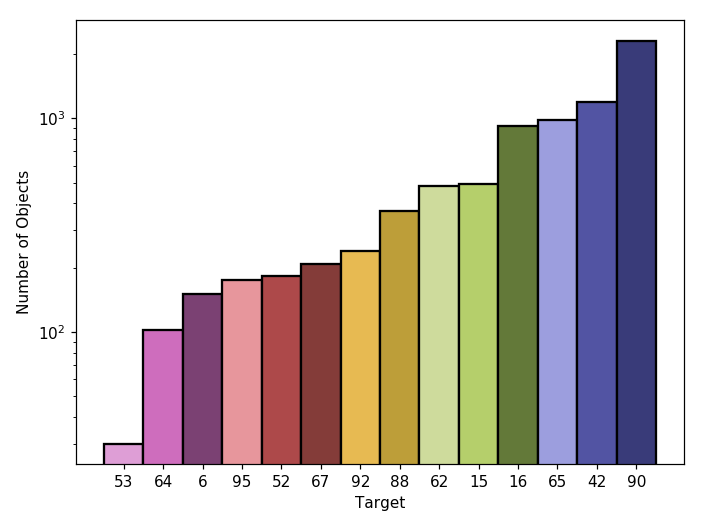

In [3]:
#---------------------------------------------------
#      true class distribution
# As inspired by the classification demo, provided by LSST on Kaggle.

counts = Counter(metadata['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20b
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

In [4]:
#------------------------------------------
#       Train data
trainfilename = f'{datadir}/training_set.csv'
traindata = Table.read(trainfilename, format='csv')
traindata


object_id,mjd,passband,flux,flux_err,detected
int64,float64,int64,float64,float64,int64
615,59750.4229,2,-544.810303,3.622952,1
615,59750.4306,1,-816.434326,5.55337,1
615,59750.4383,3,-471.385529,3.801213,1
615,59750.445,4,-388.984985,11.395031,1
615,59752.407,2,-681.858887,4.041204,1
615,59752.4147,1,-1061.457031,6.472994,1
615,59752.4224,3,-524.95459,3.552751,1
615,59752.4334,4,-393.480225,3.599346,1
615,59752.4435,5,-355.88678,10.421921,1


In [5]:
#-----------------------------------------
#     Cesium to create time series objects

tsdict = OrderedDict()
for i in tnrange(nobjects, desc='Building Timeseries'):
    row = metadata[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (traindata['object_id'] == thisid)
    thislc = traindata[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )


    
    
del traindata

features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

import warnings
warnings.simplefilter('ignore')

In [6]:
# Faster computing
def worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

# Saving the computed file.
featurefile = f'{datadir}/plasticc_featuretable.npz'
if os.path.exists(featurefile):
    featuretable, _ = featurize.load_featureset(featurefile)
else:
    features_list = []
    with tqdm_notebook(total=nobjects, desc="Computing Features") as pbar:
        with schwimmbad.MultiPool() as pool:  
            results = pool.imap(worker, list(tsdict.values()))
            for res in results:
                features_list.append(res)
                pbar.update()
            
    featuretable = featurize.assemble_featureset(features_list=features_list,\
                              time_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)
    
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
del featuretable

In [9]:
# Train / test split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['target']))[0]
train_ind, test_ind = splits

Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


<IPython.core.display.Javascript object>


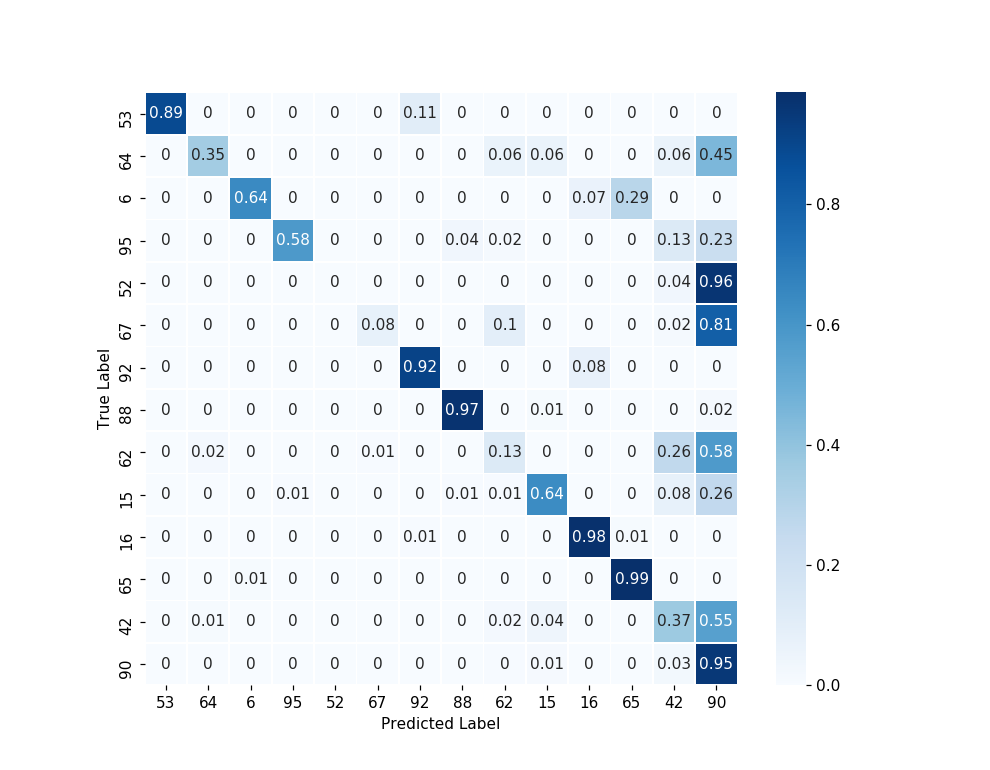

Classification accuracy: 0.7341825902335456
Weighted F-measure: 0.6969109086656139
Micro F-measure: 0.7341825902335457
Macro F-measure: 0.640428673840837
             precision    recall  f1-score   support

          6       0.91      0.64      0.75        45
         15       0.77      0.64      0.70       149
         16       0.96      0.98      0.97       277
         42       0.62      0.37      0.47       358
         52       0.00      0.00      0.00        55
         53       1.00      0.89      0.94         9
         62       0.49      0.13      0.21       145
         64       0.65      0.35      0.46        31
         65       0.95      0.99      0.97       294
         67       0.83      0.08      0.15        62
         88       0.96      0.97      0.97       111
         90       0.59      0.95      0.73       694
         92       0.96      0.92      0.94        72
         95       0.94      0.58      0.72        53

avg / total       0.73      0.73      0.70      2

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In [10]:
# Random forest
clf = RandomForestClassifier(n_estimators=200, criterion='gini',\
                       oob_score=True, n_jobs=-1, random_state=42,\
                      verbose=1, class_weight='balanced')
clf.fit(Xtrain, Ytrain)
Ypred = clf.predict(Xtest)
features = clf.feature_importances_

cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

performance_measures = {'Random forest':[],'Nearest neighbours':[], 'AdaBoost':[], 'XGBoost':[]}

accuracy = clf.score(Xtest, Ytest)
print(f'Classification accuracy: {accuracy}')
fmeasure_weight = metrics.f1_score(Ytest, Ypred, average='weighted')
print (f'Weighted F-measure: {fmeasure_weight}')
fmeasure_micro = metrics.f1_score(Ytest, Ypred, average='micro')
print (f'Micro F-measure: {fmeasure_micro}')
fmeasure_macro = metrics.f1_score(Ytest, Ypred, average='macro')
print (f'Macro F-measure: {fmeasure_macro}')

performance_measures['Random forest'].extend([accuracy, fmeasure_weight, fmeasure_micro, fmeasure_macro])

print(metrics.classification_report(Ytest, Ypred))

In [11]:
# As provided by LSST on Kaggle.

def plasticc_log_loss(y_true, y_pred, relative_class_weights=None):
        """
        Implementation of weighted log loss used for the Kaggle challenge
        """
        predictions = y_pred.copy()

        # sanitize predictions
        epsilon = sys.float_info.epsilon # this is machine dependent but essentially prevents log(0)
        predictions = np.clip(predictions, epsilon, 1.0 - epsilon)
        predictions = predictions / np.sum(predictions, axis=1)[:, np.newaxis]

        predictions = np.log(predictions)
        # multiplying the arrays is equivalent to a truth mask as y_true only contains zeros and ones
        class_logloss = []
        for i in range(predictions.shape[1]):
            # average column wise log loss with truth mask applied
            result = np.average(predictions[:, i][y_true[:, i] == 1])
            class_logloss.append(result)
        return -1 * np.average(class_logloss, weights=relative_class_weights)
    
    
    
weights = np.ones(nlines)

# we want the actual prediction probabilities
Ypred = clf.predict_proba(Xtest)

# we also need to express the truth table as a matrix
sklearn_truth = np.zeros((len(Ytest), nlines))
label_index_map = dict(zip(clf.classes_, np.arange(nlines)))
for i, x in enumerate(Ytest):
    sklearn_truth[i][label_index_map[Ytest[i]]] = 1
 
      
logloss = plasticc_log_loss(sklearn_truth, Ypred, relative_class_weights=weights)
print("LogLoss: {:.3f}".format(logloss))

LogLoss: 1.109


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


<IPython.core.display.Javascript object>


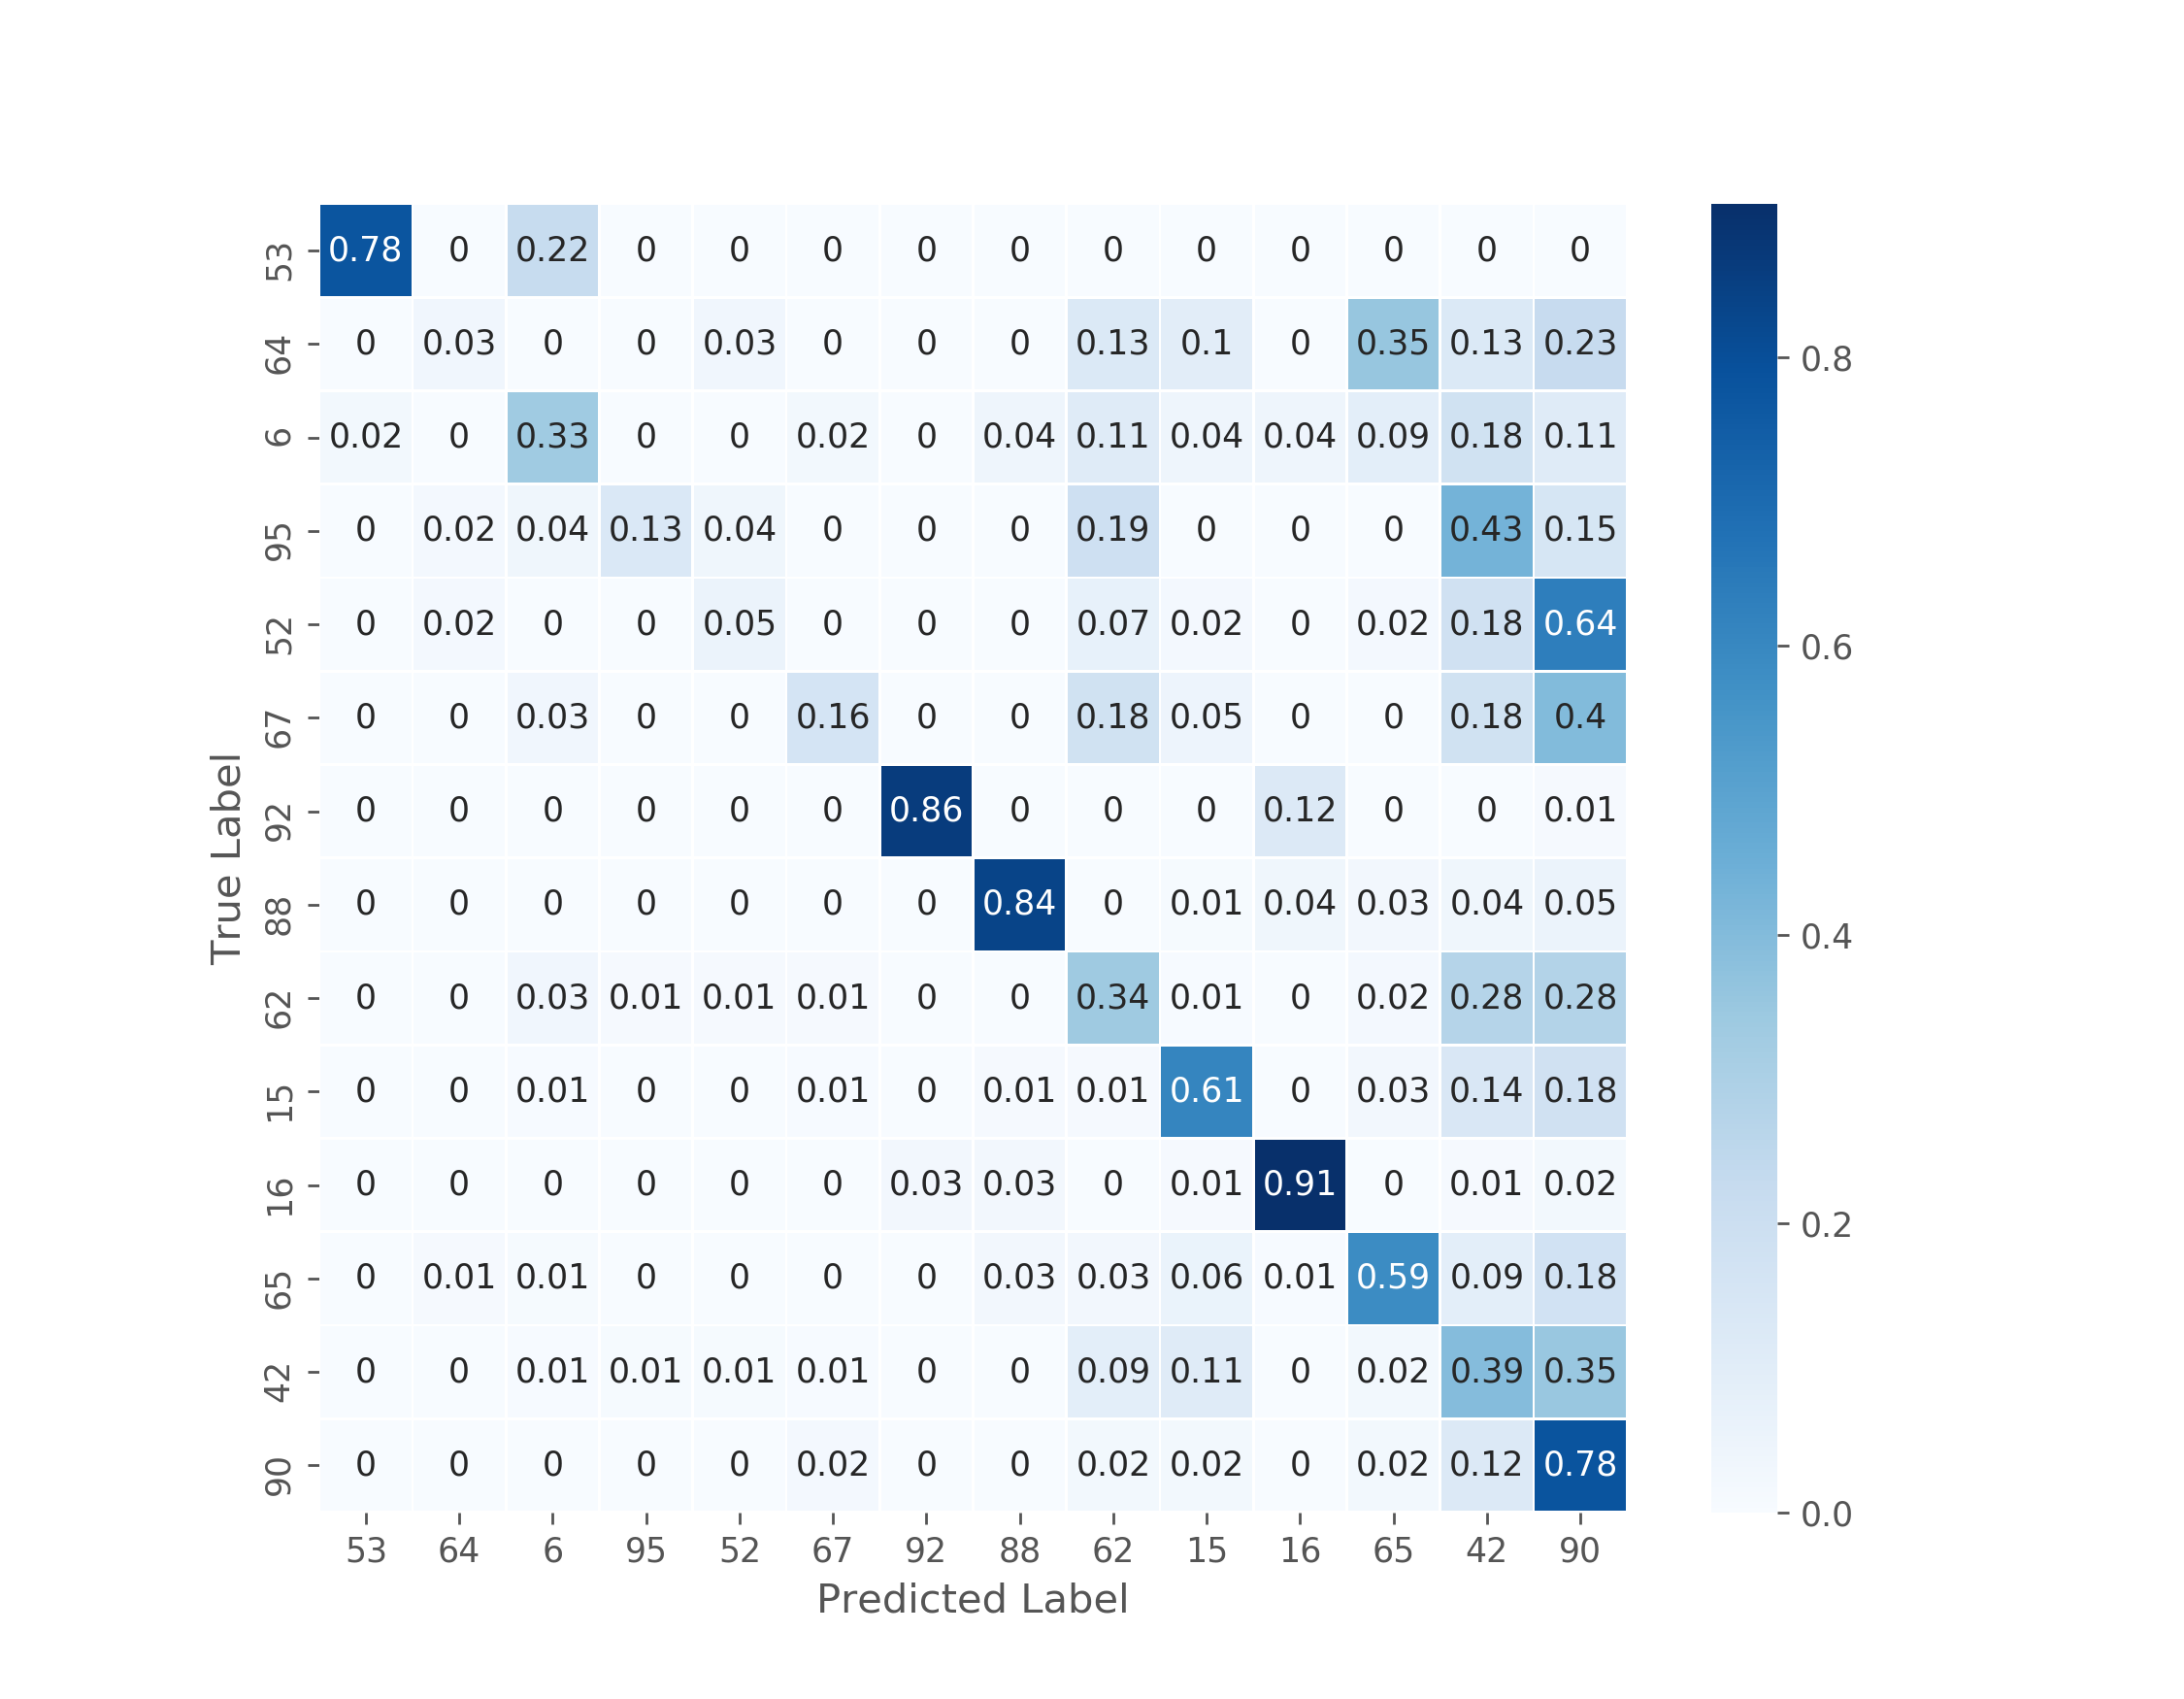

Classification accuracy: 0.6127388535031847
Weighted F-measure: 0.5983817786506859
Micro F-measure: 0.6127388535031847
Macro F-measure: 0.5033987070973827
             precision    recall  f1-score   support

          6       0.45      0.33      0.38        45
         15       0.51      0.61      0.55       149
         16       0.93      0.91      0.92       277
         42       0.37      0.39      0.38       358
         52       0.21      0.05      0.09        55
         53       0.88      0.78      0.82         9
         62       0.35      0.34      0.34       145
         64       0.11      0.03      0.05        31
         65       0.78      0.59      0.67       294
         67       0.34      0.16      0.22        62
         88       0.83      0.84      0.83       111
         90       0.61      0.78      0.69       694
         92       0.90      0.86      0.88        72
         95       0.58      0.13      0.22        53

avg / total       0.61      0.61      0.60      

In [20]:
# K Nearest Neighbor

import sklearn.neighbors as neighbour

k_neighbour = neighbour.KNeighborsClassifier(6)
k_neighbour.fit(Xtrain,Ytrain)

Ypred = k_neighbour.predict(Xtest)

cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
fig.savefig('KNeigboursHeat.png')

accuracy = k_neighbour.score(Xtest, Ytest)
print(f'Classification accuracy: {accuracy}')
fmeasure_weight = metrics.f1_score(Ytest, Ypred, average='weighted')
print (f'Weighted F-measure: {fmeasure_weight}')
fmeasure_micro = metrics.f1_score(Ytest, Ypred, average='micro')
print (f'Micro F-measure: {fmeasure_micro}')
fmeasure_macro = metrics.f1_score(Ytest, Ypred, average='macro')
print (f'Macro F-measure: {fmeasure_macro}')

performance_measures['Nearest neighbours'].extend([accuracy, fmeasure_weight, fmeasure_micro, fmeasure_macro])

print(metrics.classification_report(Ytest, Ypred))

Ypred = k_neighbour.predict_proba(Xtest)

sklearn_truth = np.zeros((len(Ytest), nlines))
label_index_map = dict(zip(clf.classes_, np.arange(nlines)))
for i, x in enumerate(Ytest):
    sklearn_truth[i][label_index_map[Ytest[i]]] = 1
 
      
logloss = plasticc_log_loss(sklearn_truth, Ypred, relative_class_weights=weights)
print("LogLoss: {:.3f}".format(logloss))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


<IPython.core.display.Javascript object>


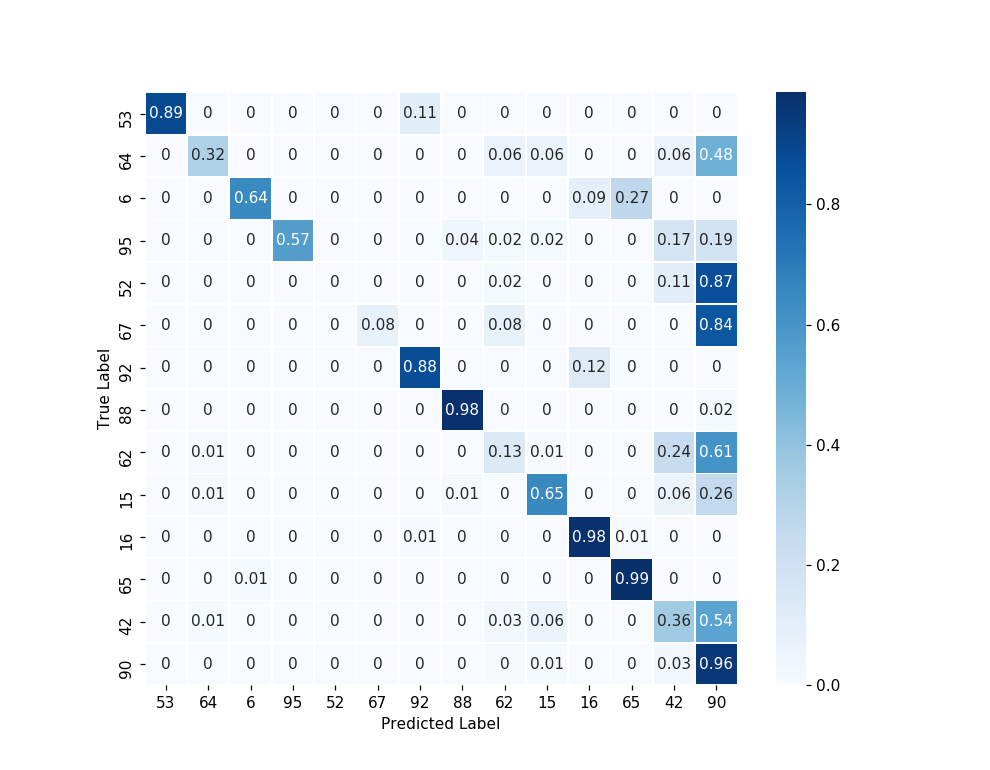

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


Classification accuracy: 0.7320594479830148
Weighted F-measure: 0.6938283163619837
Micro F-measure: 0.7320594479830148
Macro F-measure: 0.6343134615602407
             precision    recall  f1-score   support

          6       0.91      0.64      0.75        45
         15       0.75      0.65      0.70       149
         16       0.95      0.98      0.97       277
         42       0.62      0.36      0.46       358
         52       0.00      0.00      0.00        55
         53       1.00      0.89      0.94         9
         62       0.46      0.13      0.20       145
         64       0.59      0.32      0.42        31
         65       0.95      0.99      0.97       294
         67       1.00      0.08      0.15        62
         88       0.96      0.98      0.97       111
         90       0.60      0.96      0.73       694
         92       0.95      0.88      0.91        72
         95       0.97      0.57      0.71        53

avg / total       0.73      0.73      0.69      

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


In [12]:
# Ada Boost
gbc = AdaBoostClassifier(clf, n_estimators=200)
gbc.fit(Xtrain,Ytrain)
Ypred= gbc.predict(Xtest)

cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

accuracy = gbc.score(Xtest, Ytest)
print(f'Classification accuracy: {accuracy}')
fmeasure_weight = metrics.f1_score(Ytest, Ypred, average='weighted')
print (f'Weighted F-measure: {fmeasure_weight}')
fmeasure_micro = metrics.f1_score(Ytest, Ypred, average='micro')
print (f'Micro F-measure: {fmeasure_micro}')
fmeasure_macro = metrics.f1_score(Ytest, Ypred, average='macro')
print (f'Macro F-measure: {fmeasure_macro}')

performance_measures['AdaBoost'].extend([accuracy, fmeasure_weight, fmeasure_micro, fmeasure_macro])
print(metrics.classification_report(Ytest, Ypred))

Ypred = gbc.predict_proba(Xtest)

sklearn_truth = np.zeros((len(Ytest), nlines))
label_index_map = dict(zip(clf.classes_, np.arange(nlines)))
for i, x in enumerate(Ytest):
    sklearn_truth[i][label_index_map[Ytest[i]]] = 1
 
      
logloss = plasticc_log_loss(sklearn_truth, Ypred, relative_class_weights=weights)
print("LogLoss: {:.3f}".format(logloss))

<IPython.core.display.Javascript object>


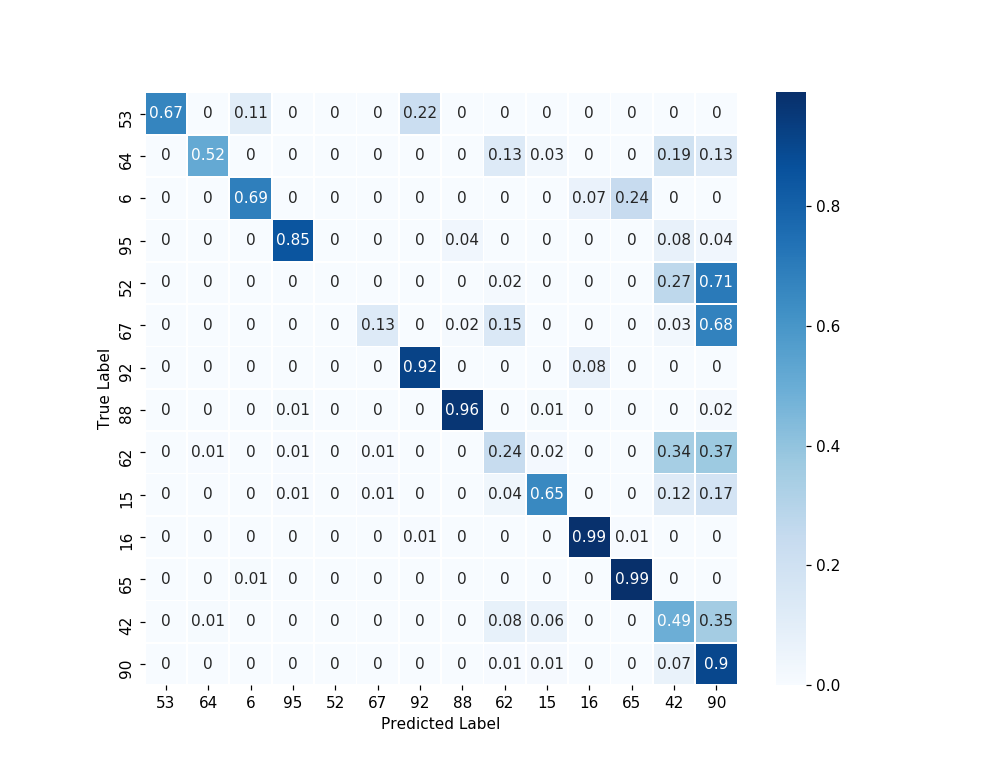

Classification accuracy: 0.7554140127388536
Weighted F-measure: 0.7315247215207296
Micro F-measure: 0.7554140127388536
Macro F-measure: 0.6720560822496452
             precision    recall  f1-score   support

          6       0.89      0.69      0.78        45
         15       0.73      0.65      0.69       149
         16       0.97      0.99      0.98       277
         42       0.55      0.49      0.52       358
         52       0.00      0.00      0.00        55
         53       1.00      0.67      0.80         9
         62       0.40      0.24      0.30       145
         64       0.73      0.52      0.60        31
         65       0.96      0.99      0.97       294
         67       0.73      0.13      0.22        62
         88       0.96      0.96      0.96       111
         90       0.68      0.90      0.78       694
         92       0.94      0.92      0.93        72
         95       0.92      0.85      0.88        53

avg / total       0.73      0.76      0.73      

In [13]:
import xgboost as xgb

# Gradient boost (XGBoost)
model = xgb.XGBClassifier()
train_model1 = model.fit(Xtrain, Ytrain)

Ypred= train_model1.predict(Xtest)

cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
fig.savefig('XGBoostHeat')

accuracy = model.score(Xtest, Ytest)
print(f'Classification accuracy: {accuracy}')
fmeasure_weight = metrics.f1_score(Ytest, Ypred, average='weighted')
print (f'Weighted F-measure: {fmeasure_weight}')
fmeasure_micro = metrics.f1_score(Ytest, Ypred, average='micro')
print (f'Micro F-measure: {fmeasure_micro}')
fmeasure_macro = metrics.f1_score(Ytest, Ypred, average='macro')
print (f'Macro F-measure: {fmeasure_macro}')

performance_measures['XGBoost'].extend([accuracy, fmeasure_weight, fmeasure_micro, fmeasure_macro])
print(metrics.classification_report(Ytest, Ypred))

Ypred = train_model1.predict_proba(Xtest)

sklearn_truth = np.zeros((len(Ytest), nlines))
label_index_map = dict(zip(clf.classes_, np.arange(nlines)))
for i, x in enumerate(Ytest):
    sklearn_truth[i][label_index_map[Ytest[i]]] = 1
 
      
logloss = plasticc_log_loss(sklearn_truth, Ypred, relative_class_weights=weights)
print("LogLoss: {:.3f}".format(logloss))

<IPython.core.display.Javascript object>


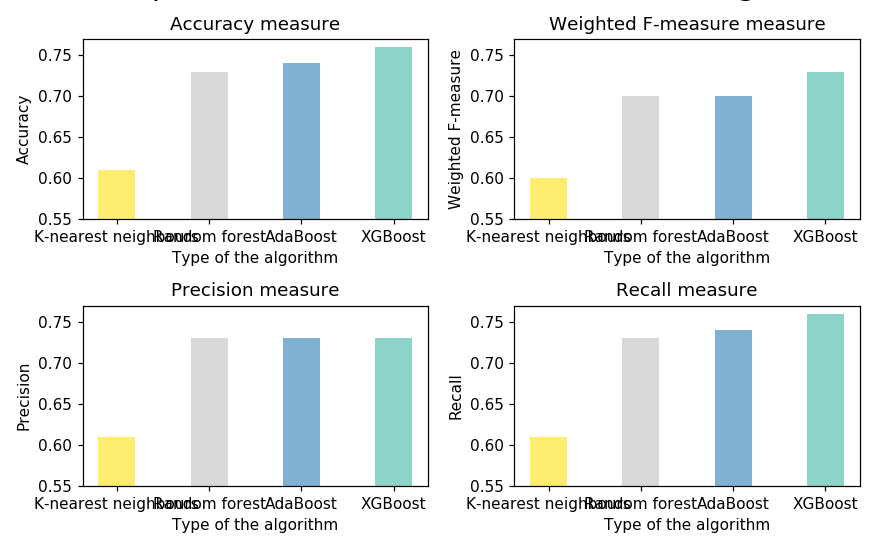

In [15]:
cmap = plt.cm.Set3
nlines = 4  
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

measures = ['Accuracy', 'Weighted F-measure', 'Precision', 'Recall']
algorithms = ['K-nearest neighbours', 'Random forest', 'AdaBoost', 'XGBoost']
performance = np.array([[0.61, 0.73, 0.74, 0.76],[0.60, 0.70, 0.70, 0.73],[0.61, 0.73, 0.73, 0.73], [0.61, 0.73, 0.74, 0.76]])

fig, axes = plt.subplots(2,2, figsize=(8,5))
axes = axes.flatten()

for i, performance_type in enumerate(performance):
    axes[i].bar(algorithms, height=performance_type, color=classcolor, width=0.4)
    axes[i].set_xlabel('Type of the algorithm')
    axes[i].set_ylabel(measures[i])
    axes[i].set_title(f'{measures[i]} measure')
    axes[i].set_ylim(ymin=0.55, ymax=0.77)

fig.tight_layout()
fig.suptitle('Different performance measures for different algorithms', fontsize='20', y=1.05)
plt.savefig('Performance.png')

<IPython.core.display.Javascript object>


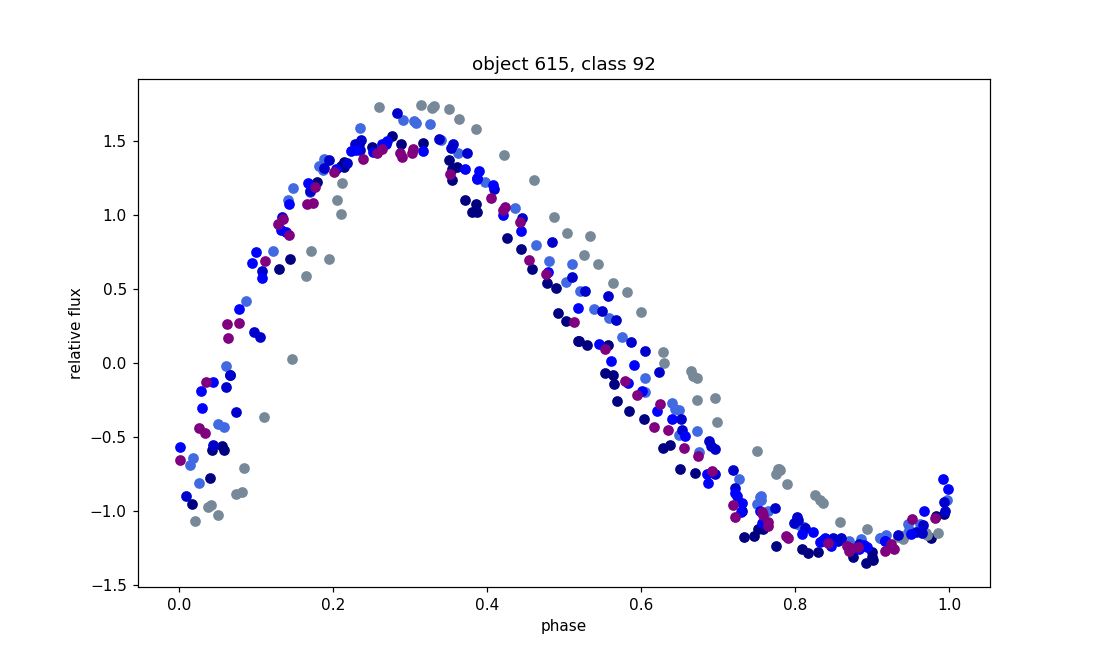

In [18]:
# Visualization of Time-Series. (takes long,)
    # Following the original visualization from Kaggle user Michael Haltuf. The original kernel can be found at:
    # https://www.kaggle.com/rejpalcz/feature-extraction-using-period-analysis
    
import pandas as pd
    
datadir = 'Data'
train_series = pd.read_csv(f'{datadir}/training_set.csv')
train_metadata = pd.read_csv(f'{datadir}/training_set_metadata.csv')
metafilename = f'{datadir}/training_set_metadata.csv'    
simple_features = train_series.groupby(
    ['object_id', 'passband'])['flux'].agg(
    ['mean', 'max', 'min', 'std']).unstack('passband')  
    
    
def time_kernel(diff, tau):
    return np.exp(-diff ** 2 / (2 * tau ** 2))    
    
t_min, t_max = train_series['mjd'].min(), train_series['mjd'].max()
t_min, t_max    
    
    
sample_points = np.array(np.arange(t_min, t_max, 20))    
weights = time_kernel(np.expand_dims(sample_points, 0) 
                      - np.expand_dims(train_series['mjd'].values, 1), 5)
ts_mod = train_series[['object_id', 'mjd', 'passband', 'flux']].copy()
for i in range(len(sample_points)):
    ts_mod[f'sw_{i}'] = weights[:, i]
    
    
def group_transform(chunk):
    sample_weights = chunk[[f'sw_{i}' for i in range(len(sample_points))]]
    sample_weights /= np.sum(sample_weights, axis=0)
    weighted_flux = np.expand_dims(chunk['flux'].values, 1) * sample_weights.fillna(0)
    return np.sum(weighted_flux, axis=0)


ts_samp = ts_mod[ts_mod['object_id'].isin([615, 713])].groupby(
    ['object_id', 'passband']).apply(group_transform)    
groups = train_series.groupby(['object_id', 'passband'])


def normalise(ts):
    return (ts - ts.mean()) / ts.std()    
times = groups.apply(
    lambda block: block['mjd'].values).reset_index().rename(columns={0: 'seq'})    
flux = groups.apply(
    lambda block: normalise(block['flux']).values
).reset_index().rename(columns={0: 'seq'})    
times_list = times.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()
flux_list = flux.groupby('object_id').apply(lambda x: x['seq'].tolist()).tolist()

    
warnings.simplefilter('ignore', RuntimeWarning)
N = 100
cfeats = featurize.featurize_time_series(times=times_list[:N],
                                        values=flux_list[:N],
                                        features_to_use=['freq1_freq',
                                                        'freq1_signif',
                                                        'freq1_amplitude1'],
                                        scheduler=None)
cfeats.stack('channel').iloc[:24]
    
def plot_phase(n, fr):
    selected_times = times_list[n]
    selected_flux = flux_list[n]
    colors = ['navy', 'lightslategray', 'royalblue', 'mediumblue', 'blue', 'purple']
    f, ax = plt.subplots(figsize=(10, 6))
    for band in range(6):
        ax.scatter(x=(selected_times[band] * fr) % 1, 
                   y=selected_flux[band], 
                   c=colors[band])
    ax.set_xlabel('phase')
    ax.set_ylabel('relative flux')
    ax.set_title(
        f'object {train_metadata["object_id"][n]}, class {train_metadata["target"][n]}')
    plt.show()

plot_phase(0, 3.081631)

<IPython.core.display.Javascript object>


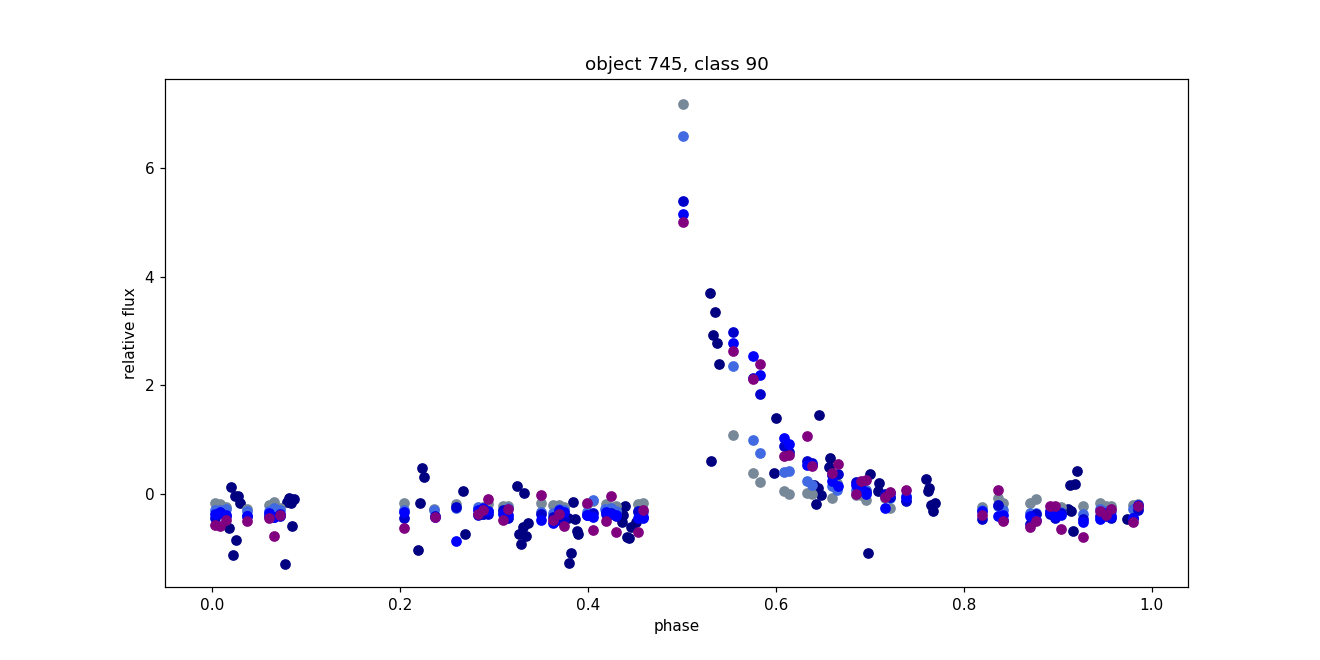

In [17]:
plot_phase(3, 0.001921)

<IPython.core.display.Javascript object>


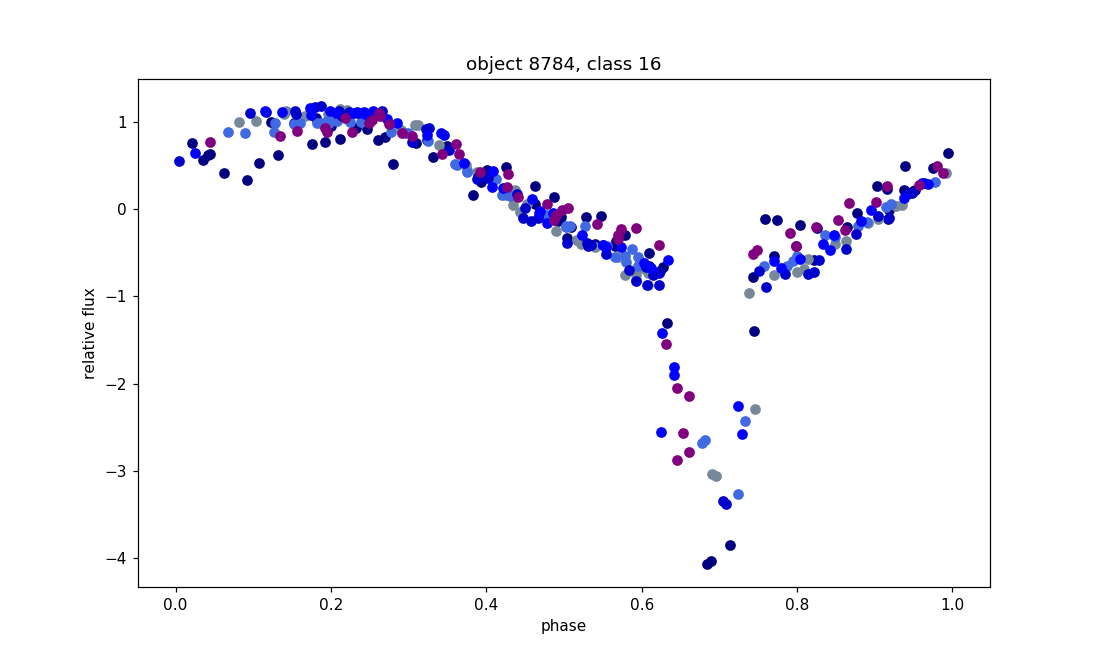

In [20]:
plot_phase(46, 1.781711)